## Starting the ga-wazpy code

Setting a few packages. The package scikit-image is needed. Install it locally using conda <br>
in the terminal and after restart the kernel. 

Run these 2 lines below in terminal and after that restart kernel:
python -m pip install -U --user pip
python -m pip install -U --user scikit-image

Transformation from DECam g and r to V absolute magnitude: V = g - 0.58*(g-r) - 0.01 (Jester 2005, from SDSS to V)

In [1]:
# Rodar no terminal e depois reiniciar o kernel:
# python -m pip install -U --user pip
# python -m pip install -U --user scikit-image
# pip install --user parsl
# conda install -c cta-observatory sparse2d

import numpy as np
import yaml
import os
import astropy.io.fits as fits
import healpy as hp
from astropy.table import Table
import json
import matplotlib as mpl
from multithread import split_equal_area_in_threads
from utils import hpx_split_survey #, split_survey_from_hpx
from utils import read_FitsCat, create_directory #, concatenate_fits
from utils import create_mosaic_footprint, create_survey_footprint_from_mosaic
from utils import add_key_to_fits, concatenate_clusters
from utils import tile_radius, create_tile_specs #, filter_hpx_tile
from utils import read_mosaicFitsCat_in_disc, create_directory 
from utils import read_mosaicFootprint_in_disc #, read_FitsFootprint
from utils import add_clusters_unique_id
from gawa import compute_cmd_masks, compute_dslices, create_gawa_directories
from gawa import gawa_tile, tile_dir_name
from gawa import cl_duplicates_filtering

import parsl
from parsl.app.app import python_app, bash_app
from parsl.configs.local_threads import config
from time import time
t0 = time()
parsl.load(config)

mpl.rcParams['legend.numpoints'] = 1
cmap = mpl.cm.get_cmap("inferno_r")

In [2]:
# @python_app
def gawa_thread_call(confg, thread_id):

    # read config file
    with open(confg) as fstream:
        param_data = yaml.load(fstream)
        globals().update(param_data)

    workdir = out_paths['workdir']

    ####
    all_tiles = read_FitsCat(os.path.join(workdir, admin['tiling']['tiles_filename']))
    tiles = all_tiles[(all_tiles['thread_id']==int(thread_id))]    
    print ('THREAD ', int(thread_id))

    for it in range(0, len(tiles)):
        tile_dir = tile_dir_name(workdir, int(tiles['id'][it]) )
        print ('..... Tile ', int(tiles['id'][it]))

        create_directory(tile_dir)
        create_gawa_directories(tile_dir, out_paths['gawa'])
        out_paths['tile_dir'] = tile_dir # local update 

        tile_radius_deg = tile_radius(admin['tiling'])
        tile_specs = create_tile_specs(tiles[it], tile_radius_deg, admin)
        data_star_tile = read_mosaicFitsCat_in_disc(starcat[survey], tiles[it], tile_radius_deg)   
        data_fp_tile   = read_mosaicFootprint_in_disc (footprint[survey], tiles[it], tile_radius_deg)

        if verbose>=2:
            t = Table (data_star_tile)#, names=names)
            t.write(os.path.join(tile_dir, out_paths['gawa']['files'],"starcat.fits"),overwrite=True)
            t = Table (data_fp_tile)#, names=names)
            t.write(os.path.join(tile_dir, out_paths['gawa']['files'], "footprint.fits"),overwrite=True)
  
        gawa_tile(tile_specs, isochrone_masks[survey], data_star_tile, starcat[survey], \
                  data_fp_tile, footprint[survey], gawa_cfg, admin, out_paths, verbose)

In [3]:
def gawa_concatenate(confg):
    # read config file
    with open(confg) as fstream:
        param_data = yaml.load(fstream)
        globals().update(param_data)

    # concatenate all tiles 
    all_tiles = read_FitsCat(os.path.join(out_paths['workdir'], admin['tiling']['tiles_filename']))
    list_results = []
    for it in range(0, len(all_tiles)):
        tile_dir = tile_dir_name(out_paths['workdir'], int(all_tiles['id'][it]) )
        list_results.append(os.path.join(tile_dir, out_paths['gawa']['results']))
    concatenate_clusters(list_results, os.path.join(out_paths['workdir'],'clusters0.fits')) 

    # final filtering 
    data_clusters0 = read_FitsCat(os.path.join(out_paths['workdir'],'clusters0.fits'))
    data_clusters0f = cl_duplicates_filtering(data_clusters0, gawa_cfg, 'survey')
    # create unique index with decreasing SNR 
    data_clusters = add_clusters_unique_id(data_clusters0f, gawa_cfg['clkeys'])
    data_clusters.write(os.path.join(out_paths['workdir'],'clusters.fits'), overwrite=True)

/tmp/ipykernel_7418/1298488997.py:6: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  param_data = yaml.load(fstream)


Survey :  MOCK
workdir :  /home/adriano.pieres/gawa/
Ntiles / Nthreads =  13  /  10
Compute CMD masks
.....Mask distance (kpc) =  81.04
.....Mask distance (kpc) =  89.72
.....Mask distance (kpc) =  99.39
.....Mask distance (kpc) =  110.17
.....Mask distance (kpc) =  122.19
THREAD  1
..... Tile  3
..........Start gawa tile catalog construction
.............. Detection in slice  0


/opt/conda/envs/gawa_env/bin/mr_filter: error while loading shared libraries: libcfitsio.so.5: cannot open shared object file: No such file or directory


FileNotFoundError: [Errno 2] No such file or directory: '/home/adriano.pieres/gawa/tiles/tile_003/gawa_files/wmap_D81.04.fits'

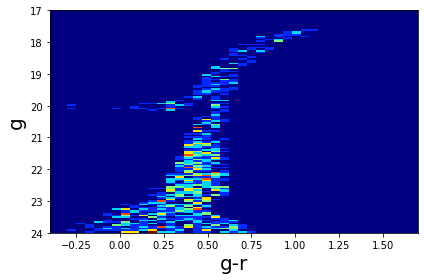

In [4]:
# read config file as online argument 
confg = "gawa.cfg" #sys.argv[1]

# read config file
with open(confg) as fstream:
    param_data = yaml.load(fstream)
globals().update(param_data)

# Working & output directories 
workdir = out_paths['workdir']
create_directory(workdir)
create_directory(os.path.join(workdir, 'tiles'))
print ('Survey : ', survey)
print ('workdir : ', workdir)
tiles_filename = os.path.join(workdir, admin['tiling']['tiles_filename'])

# store config file in workdir
with open(os.path.join(workdir, 'gawa.cfg'), 'w') as outfile:
    json.dump(param_data, outfile)

# create required data structure if not exist and update config 
if not input_data_structure[survey]['footprint_hpx_mosaic']:
    create_mosaic_footprint(footprint[survey], os.path.join(workdir, 'footprint'))
    param_data['footprint'][survey]['mosaic']['dir'] = os.path.join(workdir, 'footprint')
with open(os.path.join(workdir, 'gawa.cfg'), 'w') as outfile:
    json.dump(param_data, outfile)
confg = os.path.join(workdir, 'gawa.cfg')    

# split_area:
if input_data_structure[survey]['footprint_hpx_mosaic']: 
    survey_footprint = os.path.join(workdir, 'survey_footprint.fits')
    if not os.path.isfile(survey_footprint):
        create_survey_footprint_from_mosaic(footprint[survey],   survey_footprint)
else:
    survey_footprint = footprint[survey]['survey_footprint']

if not os.path.isfile(tiles_filename):
    ntiles = hpx_split_survey (survey_footprint, footprint[survey], admin['tiling'], tiles_filename)
    n_threads, thread_ids = split_equal_area_in_threads(admin['nthreads_max'], tiles_filename)
    add_key_to_fits(tiles_filename, thread_ids, 'thread_id', 'int')
else:
    dat = read_FitsCat(tiles_filename)
    ntiles, n_threads = len(dat), np.amax(dat['thread_id']) 
    thread_ids = dat['thread_id']
print ('Ntiles / Nthreads = ', ntiles, ' / ', n_threads)

# prepare dslices 
compute_dslices(isochrone_masks[survey], gawa_cfg['dslices'], workdir)

# compute cmd_masks 
print ('Compute CMD masks')
compute_cmd_masks(isochrone_masks[survey], out_paths, gawa_cfg)

for i in np.unique(thread_ids): 
    gawa_thread_call(confg, i)

In [6]:
gawa_concatenate(confg)

print ('all done folks!')


Concatenation starts


UnboundLocalError: local variable 'cdat' referenced before assignment